# Neural Network Training

In this homework, we will focus on the essential components involved in neural network training by implementing a simple MNIST classifier (almost like in the first week). In the last week's assignment you have discovered how fully connected layers work and even trained your first network. Now it is time to put all the information together and design a geberal algorithm that you will be able to apply to table data, images, sequences, etc.

Starting with data preparation and preprocessing, we will discuss how to build a neural network model, select appropriate activation functions, and optimize the network using gradient descent, stochastic gradient descent, and Adam optimizer.

We will then delve into loss functions, backpropagation, and updating weights, all of which are critical for effective neural network training. By the end of this assignment you will be able to train almost any network based on a universal algorithm that uses classes and modules from PyTorch for versality of training process.

## Data Preparation for Training

Data preparation is a critical step in neural network training, as it involves cleaning and organizing the data to be used in the training process.

In this section, we will discuss the two primary steps involved in data preparation, which are data loading and data preprocessing. Data loading involves reading and extracting data from various sources, while data preprocessing involves transforming and cleaning the data to ensure it is suitable for training.

### Data Loading and Data Preprocessing

In PyTorch, you can also load external datasets, such as CSV files, for use in training and testing models. To load a custom dataset, you can use the torch.utils.data.Dataset class and provide a custom data loader function.

In this example, we are creating a custom dataset class called CustomDataset that extends the torch.utils.data.Dataset class. The correct operation of the class requires defining __init__, __len__ and __getitem__ methods:
- The __init__ method provides arguments;
- The __len__ method returns the length of the dataset, and
- The __getitem__ method returns a sample from the dataset at the given index.

If a transform is provided, the sample is transformed using the provided transform function.

In [ ]:
# Install the right versions of the packages (if something went wrong)
# !pip install sklearn==1.2.2
# !pip install matplotlib==3.7.1
# !pip install PIL==8.4.0
# !pip install torch==2.0.0+cu118
# !pip install torchvision==0.15.1+cu118
# !pip install numpy==1.22.4

In [3]:
import torch
from torch.utils.data import Dataset
from PIL import Image

# define the Custom Dataset class
class RandomImageDataset(Dataset):
    def __init__(self, num_images, image_size, transform=None):
        self.num_images = num_images
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        image = Image.fromarray(torch.rand(self.image_size, self.image_size, 3).mul(255).byte().numpy())
        if self.transform:
            image = self.transform(image)
        return image, 0


You can find the most popular transforms in `torchvision.transforms`. We often do the following steps:
- Resize all the images, so that they have the same size;
- Convert to `torch.tensor`.

Additionally, you can provide some more:
- Make CentralCrop. Resizing an image can change its aspect ratio, which can distort the image if not corrected. A central crop helps to preserve the original aspect ratio of the image by removing the excess pixels that were added or removed during the resizing process;
- You can also Normalize the images providing the mean and std for each channel. It improves convergence, numerical stability and model transferability (train it and use latter for downstream tasks with other images).

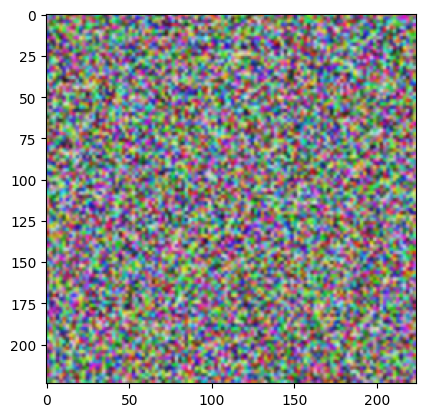

In [4]:
from torchvision import transforms
import matplotlib.pyplot as plt

# add transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# initialize Custom Dataset class
dataset = RandomImageDataset(num_images=10, image_size=128, transform=transform)

image, label = dataset[0]

# convert the tensor to a numpy array
image = image.numpy().transpose((1, 2, 0))

# display the image
plt.imshow(image)
plt.show()

The MNIST dataset is a popular dataset in machine learning and computer vision, consisting of 70,000 grayscale images of handwritten digits, with 60,000 images for training and 10,000 images for testing.

In PyTorch, we can use the torchvision package to download and load the MNIST dataset. The following code shows how to load the MNIST dataset.

Here we added some more transforms to artificially enlarge the dataset. In particular, we added rotation of any image on some angle between -10 and 10 degrees (be careful with larger angles - the number 6 rotated on 180 degrees becomes 9) and random affine transformation.

Note, we do not apply rotations to the images from the test set to keep it intact.

In [5]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# Define the transforms to be applied to the images
train_transform_no_normalize = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset with the defined transforms
trainset_no_normalize = MNIST(root='./data', train=True, download=True, transform=train_transform_no_normalize)
trainset = MNIST(root='./data', train=True, download=True, transform=train_transform)
testset = MNIST(root='./data', train=False, download=True, transform=test_transform)

It is quite a good time to talk about the reproducibility of your results. Each time some random emerges in code we make our code unstable to any changes. Even changing the order of running the cells makes a difference. That is why before creating the dataloaders (that have random shuffle) and solving Task 1 we fix all random states that we can with the following function. In this case fixing the seeds guarantees that regardless of any factors each time the same objects will form the same batches.

In [6]:
import random
import os
import numpy as np

def seed_everything(seed):
    # fix all types of random that we can
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

#### Task 1 (1 point)

As you see, we have created `trainset_no_normalize` and `trainset`. The only difference between them is that the former does not have Normalize in transforms list, the latter has it. Let us say that the mean of the values of the tensor of the *first* (index 0) element in each of them is X and Y respectively. The standard deviations are A and B respectively.

**Question**: write down $|X-Y| + |A-B|$. The result will be a floating point value rounded up to 3 decimal points.

**Sample answer**: `1.234`

**Warning**: do not change the seed!

**Hint**: do not forget that `trainset.data` returns the values without transforms, while `trainset` returns those with transforms. In this task we want you to get the statistics from transformed data. Using `trainset.data` may result in unexpected behaviour, that is why we ask you to use `trainset` instead. For better reproducibility, after fixing the seeds store the required objects from `trainset_no_normalize` and `trainset` in variables and then compute the statistics.

In [25]:
seed_everything(42)
X = np.array([])
Y = np.array([])
A, B = np.array([]), np.array([])
for im in trainset_no_normalize:
    X = np.append(X, im[0].mean())
    A = np.append(A, im[0].std())

for im in trainset:
    Y = np.append(Y, im[0].mean())
    B = np.append(B, im[0].std())
X = X.mean()
Y = Y.mean()
A = A.mean()
B = B.mean()
answer = np.abs(X - Y) + np.abs(A - B)

In [28]:
round(answer, 3)

0.808

As long as the answer is not 0 this means that the Normalize transform really changes the scale of the images! The values of mean 0.1307 and std 0.3081 we emrirically collected after applying normalization to the MNIST dataset.

### Dataloaders in PyTorch

Now we create dataloaders from `trainset` and `testset` to split the data into batches. The small datasets may be precessed without this splitting, but in the majority of cases we do not have enough resources to store everything. That is why we process the data in separate parts. The size of the batch will be 64.

For train dataloader we also define `shuffle=True`, so that the objects will be shuffled before splitting into batches. This means that for the sake of reproducibility we should fix the seeds before that. Test dataloader does not need shuffling as it is only use to evaluate the performance of the model.

In [29]:
seed_everything(42)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

#### Task 2 (1 point)

We have created the Dataloaders. But there is a question: what happens when the number of objects in the dataset cannot be divided into equal batches of the same size? In fact, we know that this concerns only the last batch from the dataloader.

**Question**: write down the size (the number of objects) of the last batch in `train_dataloader`. The answer will be an integer.

**Sample answer**: `42`

In [48]:
answer = len(trainset) % 64

Is it equal to `batch_size`? If no, this means that sometimes we cannot calculate the metrics by averaging the metrics of the batches. For example, if we evaluate the performance of the model with RMSE, we cannot compute RMSE for each batch and then divide their sum by the number of batches. In this case there is also is a difference that is connected with the behavior of the suqare root function. But the shape of the last batch also matters.

## Model Building

Model building is a crucial step in the process of creating a machine learning model. It involves designing and constructing a neural network architecture or other algorithmic structure that is capable of learning from the training data and making accurate predictions on new, unseen data.

### Creating a Model Architecture

Defining the model architecture is a critical step in model building as it determines the overall structure and complexity of the neural network or algorithmic model. The model architecture defines the arrangement of layers, the activation functions used, and how the layers are interconnected to create the final output of the model.

Let us start with a simple model. Do not forget to fix the seeds as the weights are initialized from some random distribution.

In [49]:
from torch import nn

seed_everything(42)
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=1)
)

In [50]:
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=10, bias=True)
  (4): Softmax(dim=1)
)

In PyTorch, the `torch.nn.Sequential` class is used to create a sequential neural network model by stacking multiple layers in a specific order. The order always remains as it was stated while creating the model.

#### Task 3 (1 point)

This model is not optimized for our data. But as you may remeber the weights are not zero. Coming from *He initialization* they are real values:
$$
w_i \sim N(0, \frac{2}{N_{input}})
$$
$$
w_i \sim U(-\sqrt{\frac{6}{N_{input}}}, \sqrt{\frac{6}{N_{input}}})
$$

**Question**: compute the sum of norms (frobenius) of all the parameters matrices:

$$
answer=\sum\limits_{i=1}^N \lVert X \rVert_F
$$

The answer will be a floating point value. Round it up to 3 decimal points.

**Sample answer**: `1.234`

**Hint**: the parameters are stored in `model.parameters()`.

In [58]:
sum = 0
for param in model.parameters():
    if isinstance(param, torch.nn.Parameter):
        sum += param.norm('fro')
sum

tensor(8.7252, grad_fn=<AddBackward0>)

In [59]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

1.weight tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
        [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
        [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
        ...,
        [-0.0195,  0.0034,  0.0302,  ..., -0.0030, -0.0317,  0.0128],
        [-0.0107,  0.0221, -0.0158,  ..., -0.0121,  0.0042,  0.0318],
        [-0.0106,  0.0342,  0.0240,  ...,  0.0091,  0.0174,  0.0041]])
1.bias tensor([-8.6770e-04,  2.6513e-02,  2.4231e-02,  3.5641e-03, -3.2895e-02,
         2.1752e-02,  3.3599e-02, -8.3219e-03, -8.0973e-03, -5.9837e-03,
        -1.4779e-03,  3.3858e-02,  1.4686e-02, -3.0424e-02, -1.8899e-02,
        -2.9557e-03, -1.8481e-02, -3.1352e-02,  1.0393e-02,  2.9328e-02,
         7.0543e-03, -4.0150e-03,  3.5635e-02, -1.4162e-02, -2.2133e-02,
        -5.1215e-03, -2.4719e-02, -3.9738e-04, -3.5351e-02, -3.3005e-02,
        -2.7573e-03,  2.1939e-02,  3.9803e-03, -3.4279e-02,  2.9155e-02,
         3.0087e-02, -2.6676e-04,  2.14

In [ ]:
answer = 8.7252 # YOUR_CODE_HERE

#### Task 4 (1 point)

See? In fact, we can even get the outputs of this model. But as far as it is not trained on our data, these outputs will show totally poor results. Why do not we try? Just to make sure.

The model outputs 10 values after SoftMax transform. So, we can consider them to be probabilities of each of 10 classes.

**Question**: take the first batch from `train_dataloader`, feed the data to the `model` and calculate the accuracy based on the target values from this batch. The answer will be a floating point value rounded up to 3 decimal points.

**Sample answer**: `1.234`

**Warning**: do not change the seed!

**Hint**: as the model outputs for all the objects 10 probabilities, use `argmax` to get the class with the largest probability.

In [73]:
seed_everything(42)
model.eval()
images, labels = next(iter(train_dataloader))
output = model(images)
_, predicted = torch.max(output, 1)
correct = (predicted == labels).sum()
total = labels.size(0)
correct / total

tensor(0.0781)

### Adding Layers

The architecture of a neural network typically includes several types of layers, such as:

- Input layer: This layer is responsible for accepting the input data and passing it to the next layer.

- Hidden layers: These layers are responsible for transforming the input data into a more abstract representation that the model can use to make predictions.

- Output layer: This layer produces the final output of the model, which can be a prediction for a classification problem or a continuous value for a regression problem.

Interesting fact: in PyTorch you can add to your architecture any type of layer that is implemented in PyTorch. Any order, any layers. It is all up to you to decide. You can even add layers whose principles of operation you do not fully understand. The main problem of designing a network is the dimensional mismatch between the layers. The outputs of one layer serve as the input for the next layer.

Initialize the model.

In [119]:
seed_everything(42)
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 512),
    nn.MaxPool1d(3),
    nn.ReLU(),
    nn.Linear(170, 256),
    nn.MaxPool1d(3),
    nn.ReLU(),
    nn.Linear(85, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.MaxPool1d(3),
    nn.ReLU(),
    nn.Linear(21, 32),
    nn.ReLU()
)

You have initialized a model. And only now you understand that you have completly forgotten to add some layers at the end. You do not have to change the structure above. It will be enough juct to manually add the layers with `model.add_module`.

In [115]:
seed_everything(42)
model.add_module('linear', nn.Linear(32, 10))
model.add_module('softmax', nn.Softmax(dim=-1))

In [92]:
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=64, bias=True)
  (10): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (11): ReLU()
  (12): Linear(in_features=64, out_features=32, bias=True)
  (13): ReLU()
  (linear): Linear(in_features=32, out_features=10, bias=True)
  (softmax): Softmax(dim=-1)
)

It this model apropriate from the perspective of the dimensionalities? Let us check it...

In [120]:
seed_everything(42)
input = torch.randn(1, 28, 28)
try:
    output = model(input)
except Exception as e:
    print(f'Ooops. Something went wrong. The error occured: {e}')

#### Task 5 (1 point)

As you can see, the networks fails to perform on a single image due to the fact that the dimensions of the different layers do not match. That is not a rare situation. Sometimes you will have to debug your code based on the error messages received from the interpreter.

**Question**: debug this model. All you need is to make this network work. You are not to delete any layers. Only change the number of neurons. Write down the overall number of the parameters of the network. The answer will be an integer. For this task for the sake of reproducibility you are not supposed to change more than one parameter in a layer.

**Sample answer**: `123`

**Warning**: do not change the seed!

**Hint**: the error messages usually provide enough information to make necessary changes. Start debugging from the top of the network, read the error messages carefully and make necessary changes.

In [122]:
param_sum = 0
for params in model.parameters():
    param_sum += len(params)

In [123]:
seed_everything(42)
answer = param_sum

In [124]:
param_sum

1984

#### Model as a class

Going back to adding all possible layers. That is the right way to show, why sometimes we are not satisfied with `nn.Seqential` and resort to `nn.Module`.

In [125]:
seed_everything(42)
model = nn.Sequential(
    nn.Conv2d(1, 16, 3),
    nn.BatchNorm1d(16),
    nn.SiLU(),
    nn.AvgPool2d(3),
    nn.LSTM(16, 12),
    nn.SELU(),
    nn.Flatten(),
    nn.Linear(500, 128),
    nn.GELU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=1)
)

This model is a complete mix of different types of layers. This is just an example of some architecture. We haven't studied some of the layers yet, so you don't need to do look for the information about them. The basic principles of how these layers function will be discussed in the following weeks. Fo now we are not to go into them. Consider this layers as some transformations of data that return the outputs.

Let us also abstract away from the meaninglessness of this architecture. See the problem? Try to feed a random matrix of 28 x 28 pixels to this model.

In [126]:
seed_everything(42)
input = torch.randn(1, 28, 28)

In [127]:
try:
    output = model(input)
except Exception as e:
    print(f'Ooops. Something went wrong. The error occured: {e}')

Ooops. Something went wrong. The error occured: running_mean should contain 26 elements not 16


Here it is. We need to fix the dimensionalities. But even if you try it, you will finally come to the network that still does not work. Why? The `nn.LSTM` layer outputs a tuple of tensors, but not a single tensor to convey it to the next layer of the model.

It turns out that we cannot perform everything that we want using only `nn.Sequential` models. We need to customize the model on a deeper level. At least, we want to be able to control the outputs of all the layers, so that we do not stumble on the layers that output the types other than tensors. And we can also get rid of `nn.Flatten` as long as we control the data flow in the network.

Now we will rewrite out first network using `nn.Module`.

In [129]:
class MNIST_Net(nn.Module):
    def __init__(self, num_hidden):
        super(MNIST_Net, self).__init__()
        self.fc1 = nn.Linear(784, num_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(num_hidden, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In this example, we define a class called `MNIST_Net` that inherits from `nn.Module`. In the constructor (__init__), we define the layers of the network as attributes of the class, including two fully connected layers with ReLU activation, followed by a softmax activation function.

In the **forward** method, we define the forward pass of the network, including reshaping the input data to a tensor of shape (batch_size, 784), applying the fully connected layers with ReLU activation, and finally applying the softmax activation function to produce a probability distribution over the 10 classes.

Note that the **view** method is used to reshape the input data to the appropriate shape for the first fully connected layer (instead on `nn.Flatten`). The **-1** argument in the view method indicates that the size of that dimension should be automatically inferred based on the size of the other dimensions and the total number of elements in the tensor.

#### Task 6 (0.5 points)

The interface remains the same. So you can do the same things with this model.

**Question**: initialize the model with 128 hidden neurons and write down the overall number of the parameters of the network. The answer will be an integer.

**Sample answer**: `123`

**Warning**: do not change the seed!

In [130]:
seed_everything(42)
model = MNIST_Net(128)
param_sum = 0
for params in model.parameters():
    param_sum += len(params)
param_sum

276

## Optimizers and Loss functions

Optimizers are algorithms used in neural networks to update the parameters of the model during training. The goal of optimization is to find the set of parameter values that minimize a loss function, which measures the difference between the model's predictions and the true labels.

There are many different optimizers that can be used in neural networks, each with its own advantages and disadvantages. Some of the most commonly used optimizers include:
- SGD
- Adagrad
- RMSprop
- Adam
- AdamW

We will find out how the differ.

### Useful functions

Later we will discover the differences between various algorithms. But in order to compare them we need to make sime kind of benchmark. We will vizualize the convergence of the algorithms on a plot.

Make an artificial dataset to ease the visialization. Let us say, that the dataset $X$ consists of only two features that we generated from the following distributions:

$$
X^{(1)} \sim U[-5, 5]
$$
$$
X^{(2)} \sim U[-10, 10]
$$
$$
X = (X^{(1)}, X^{(2)})
$$

Here $W$ represents the real weights of the model used to calculate the target. The target itself is just $X*W$ with some noise from normal distribution so that there was not an ideal solution:

$$
Y = Xw+\varepsilon
$$
$$
\epsilon \sim N(0, 1)
$$

In [131]:
np.random.seed(42)
n_objects = 1000
n_features = 2
X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
W = np.random.normal(size=(n_features,))
Y = X.dot(W) + np.random.normal(0, 1, (n_objects))
# starting point for gradient descent algorithms, do not change it
start = np.random.uniform(-2, 2, (n_features))

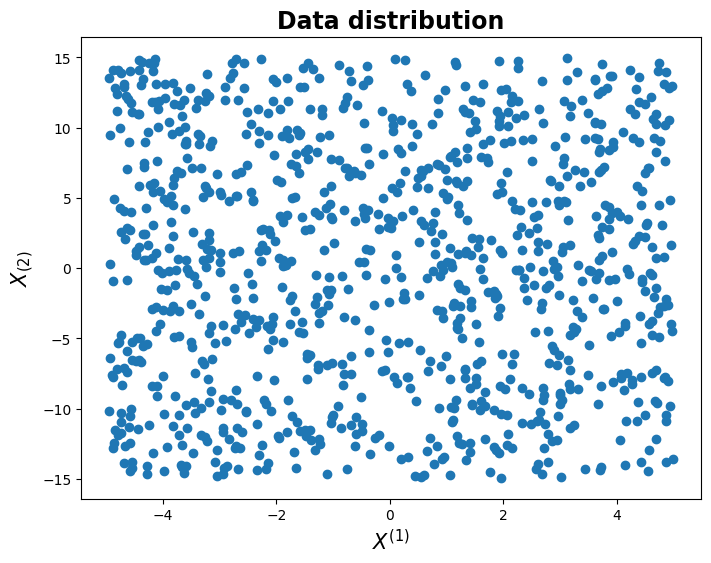

In [132]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1])
plt.title('Data distribution', size=17, weight='heavy')
plt.xlabel(r"$X^{(1)}$", size=15)
plt.ylabel(r"$X_{(2)}$", size=15)
plt.show()

### Loss function

And finally we need the loss function. It is essential to define the loss function when using optimizers in PyTorch. The optimizer updates the model parameters based on the gradients of the loss function with respect to the model parameters. Therefore, the loss function serves as a measure of how well the model is performing on the task at hand. Without a defined loss function, there is no objective measure to optimize for, and the optimizer has no direction to update the model parameters.

As long as we solve the regression task, we will use one of the most popular functions - Mean Squared Error:
$$
MSE=\frac{1}{N}\lVert Xw-y \rVert^2
$$


#### Task 7 (0.5 points)

Having the formula you can implement it in code. Gradient Descent algorithm requires for each step computing the gradient. You will also need the formula for it.

**Question**: differenciate MSE with respect to the weights `w`, complete the functions that compute the values of loss and gradients, then find $MSE$ and the gradient $\nabla_w MSE$ for our `X` dataset, weights `W` and target `Y` that we have initialized previously. Write down $MSE + \lVert \nabla_w MSE \rVert_2$. The answer will be a floating point value. Round it up to 3 decimal points.

**Sample answer**: `1.234`

You will also need the gradient formula to focus only on Gradient Descent. Gradients are simply partial derivatives according to loss weights. So your next task is to find the gradient and implement it as a python function

In [186]:
def mse(x, w, y):
    return 1/len(x) * np.linalg.norm(x @ w - y, ord=2) ** 2

def mse_grad(x, w, y):
    return 2/len(x) * x.T @ (x @ w - y)

In [173]:
answer = mse(X, W, Y) + np.linalg.norm(mse_grad(X, W, Y), 2)
answer

1.6278376473227725

### Gradient Descent

Gradient descent is an iterative optimization algorithm used in neural network training. It works by computing the gradient of the loss function with respect to the parameters of the model, and then updating the parameters in the direction of the negative gradient to minimize the loss.

Surely, the optimal code to implement the gradient descent algorithm is already presented in PyTorch, there is no need to implement it from scratch. But for our puposes we will gradually trace the evolution of this algorithm, starting from regular Gradient Descent up to Adam.

The algorithm is as follows:

1. Initialize starting point $w^{(0)}$;
2. Compute the gradient $\nabla_w Q(X, w^{(0)}, Y)$;
3. Make a step: $w^{(k)}=w^{(k-1)}-\eta*\nabla_w Q(X, w^{(k-1)}, Y)$;
4. Repeat 2-3 until stopping criterion:
  - $\lVert \nabla_w Q(X, w^{(k)}, Y) \rVert \le \varepsilon$
  - $\lVert w^{(k)} - w^{(k-1)} \rVert \le \varepsilon$
  - $n_{iter} \ge \lambda$
  - etc.

#### Task 8 (1 point)

Having the algorithm you can implement Gradient Descent.

**Question**: complete the function and run the cell with below to run the function on our previously generated data. As a result, you will get an array with the weights for each step of the algorithm. The answer is the sum of the last weights in the array. The answer is rounded up to 3 decimal points.

**Sample answer**: `1.234`

**Hint**: it may be useful sometimes to use the copies of the weights (`w.copy()`). And also do not forget the the starting point $w_0$ is incuded in the array and in the number of iterations.

In [174]:
def gradient_descent(x, w_0, y, learning_rate, n_iter):
    w = w_0.copy()
    trajectory = [w.copy()]
    i = 0
    while i < n_iter:
        curr_grad = mse_grad(x, w, y)
        w -= learning_rate * curr_grad
        trajectory.append(w.copy())
        i += 1
    return np.array(trajectory)
trace = gradient_descent(X, start, Y, 0.0001, 1000)

Do not change the cell below. It gets the trajectory - the weights for all the iterations of Gradient Descent. The starting point ot initial point $w_0$ should remain the same - `start` that we have created earlier. Using this initial state allows to exclude any element of random.

In [175]:
answer = np.around(trace[-1].sum(), 3)
answer

-1.437

Let us check how much computational time does it take to calculate for 1000 iterations.

In [161]:
%%timeit
trace = gradient_descent(X, start, Y, 0.0001, 1000)

85.2 ms ± 6.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Run the cell below to draw the plot that shows how MSE depends on the weights of all the iterations of the algorithm and different `learning_rate` options. To get rid of warnings let us also filter them.

In [162]:
import warnings
warnings.filterwarnings('ignore')

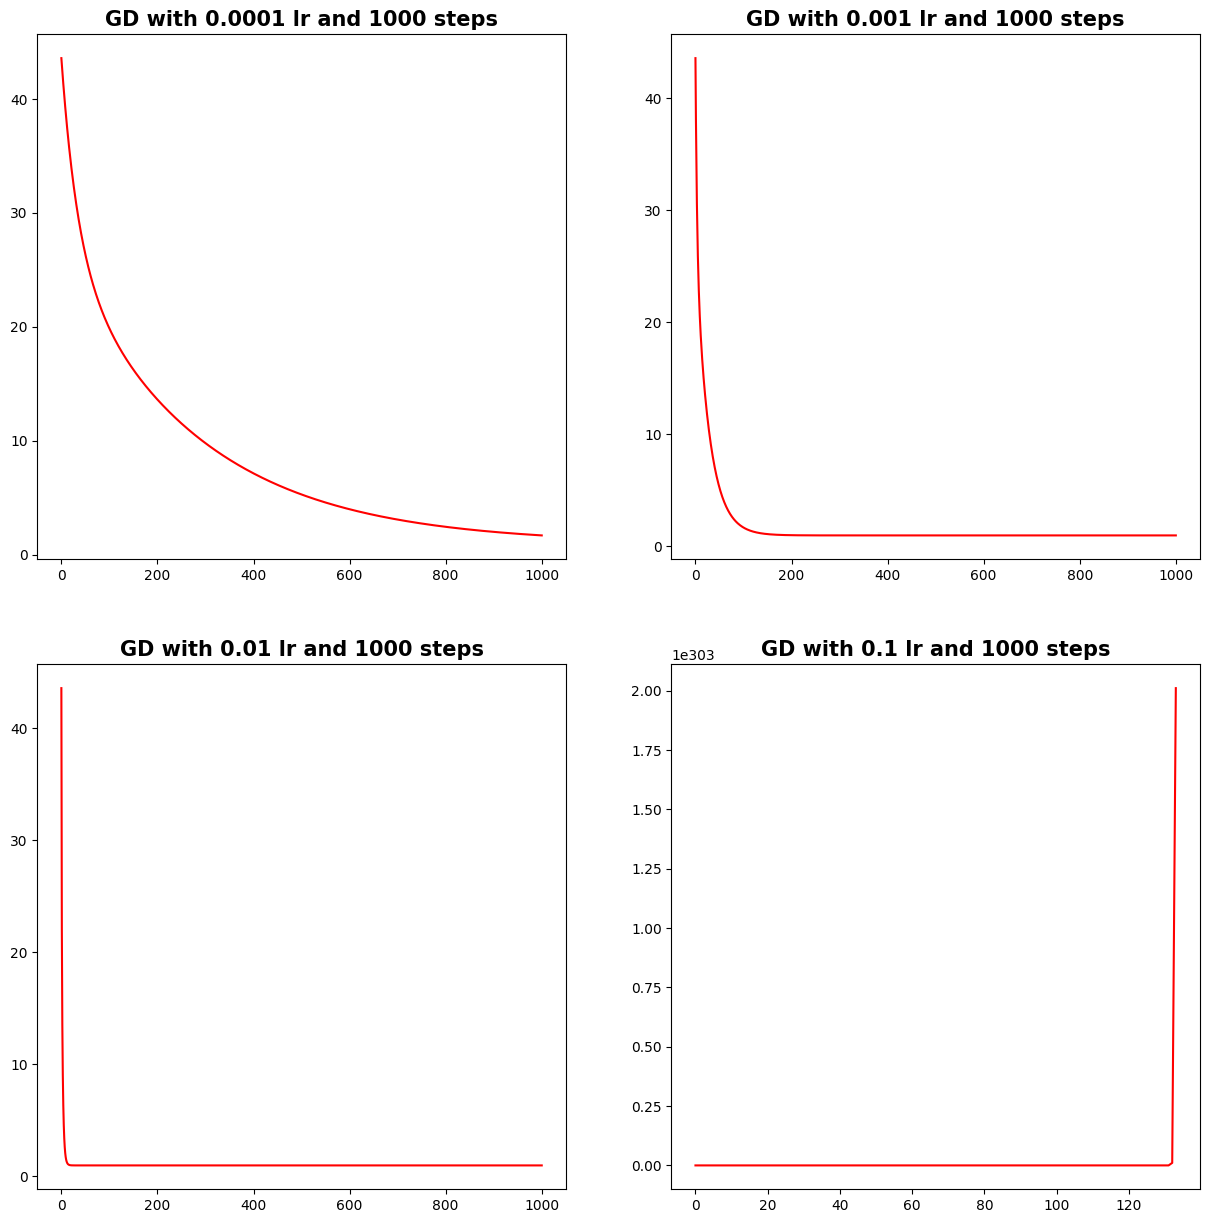

In [176]:
from matplotlib import gridspec

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(2, 2)
for lr, grd in zip([0.0001, 0.001, 0.01, 0.1],
                   [0, 1, 2, 3]):
    trace = gradient_descent(X, start, Y, lr, 1000)
    errors = np.array([mse(X, w, Y) for w in trace])
    ax = fig.add_subplot(gs[grd])
    ax.set_title(f'GD with {lr} lr and 1000 steps', size=15, weight='heavy')
    ax.plot(np.arange(0, errors.shape[0]), errors, '-r')

As you may see larger `learning_rate` values can lead not only to faster convergence. With 0.1 or more it fails to converge. In fact, the error starts to grow uncontrollably. The last plot shows that after around 130 iterations with `learning_rate=0.1` the MSE becomes $2*10^{303}$. That is why you should choose `learning_rate` wisely. Smaller values lead to slow convergence, while large values can explode the gradients and error.

### Stochastic and Mini-batch Gradient Descent

Stochastic and Mini-batch Gradient Descent are the variant of the gradient descent algorithm that updates the model parameters based on a small random subset of the training data at each iteration, rather than the entire training dataset.

The algorithm is mainly the same. The only difference between SGD and Mini-batch GD is that the first one computes the gradients only for a single object on each step, while the second one uses batches - random groups of objects.

The algorithm:

1. Initialize starting point $w^{(0)}$;
2. Get a subset of objects $X'$ that consists of 1 or more objects;
2. Compute the gradient $\nabla_w Q(X', w^{(0)}, Y)$;
3. Make a step: $w^{(k)}=w^{(k-1)}-\eta*\nabla_w Q(X', w^{(k-1)}, Y)$;
4. Repeat 2-3 until stopping criterion:
  - $\lVert \nabla_w Q(X', w^{(k)}, Y) \rVert \le \varepsilon$
  - $\lVert w^{(k)} - w^{(k-1)} \rVert \le \varepsilon$
  - $n_{iter} \ge \lambda$
  - etc.

#### Task 9 (1 point)

The algorithms is almost the same. There are some changes.

**Question**: complete the function and run the cell with below to run the function on our previously generated data. As a result, you will get an array with the weights for each step of the algorithm. The answer is the sum of the last weights in the array. The answer is rounded up to 3 decimal points.

**Sample answer**: `1.234`

**Hint**: you may use your code from the previous function. Use `np.random.choice` function to get the indices of the objects that will form a batch. Do not fix the seed inside of the function `stochastic_gradient_descent`. Pass `batch_size` to `np.random.choice` to ensure that you are picking completely random indices without repetitions.

In [188]:
def stochastic_gradient_descent(x, w_0, y, learning_rate, batch_size, n_iter):
    w = w_0.copy()
    trajectory = [w.copy()]
    i = 0
    while i < n_iter:
        indices = np.random.choice(range(len(x)), batch_size, replace=False)
        curr_grad = mse_grad(x[indices], w, y[indices])
        w -= learning_rate * curr_grad
        trajectory.append(w.copy())
        i += 1
    return np.array(trajectory)

np.random.seed(42)
trace = stochastic_gradient_descent(X, start, Y, 0.0001, 1, 1000)

In [189]:

answer = np.around(trace[-1].sum(), 3)
answer

-1.454

Compare the computation speed.

In [190]:
%%timeit
trace = stochastic_gradient_descent(X, start, Y, 0.0001, 1, 1000)

142 ms ± 7.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Even though we spend less resources for computing the gradients as we use only one object, we still spend them on sampling an object from dataset. That is why we need more time to compute it. But with larger datasets the situation is fundamentally changing. Suppose we have a dataset that consists of 1 million of objects. DO you think the required time will be distributed the same way?

One more time we will visualize the values of the loss function for the weights from all the iterations with different hyperparameters.

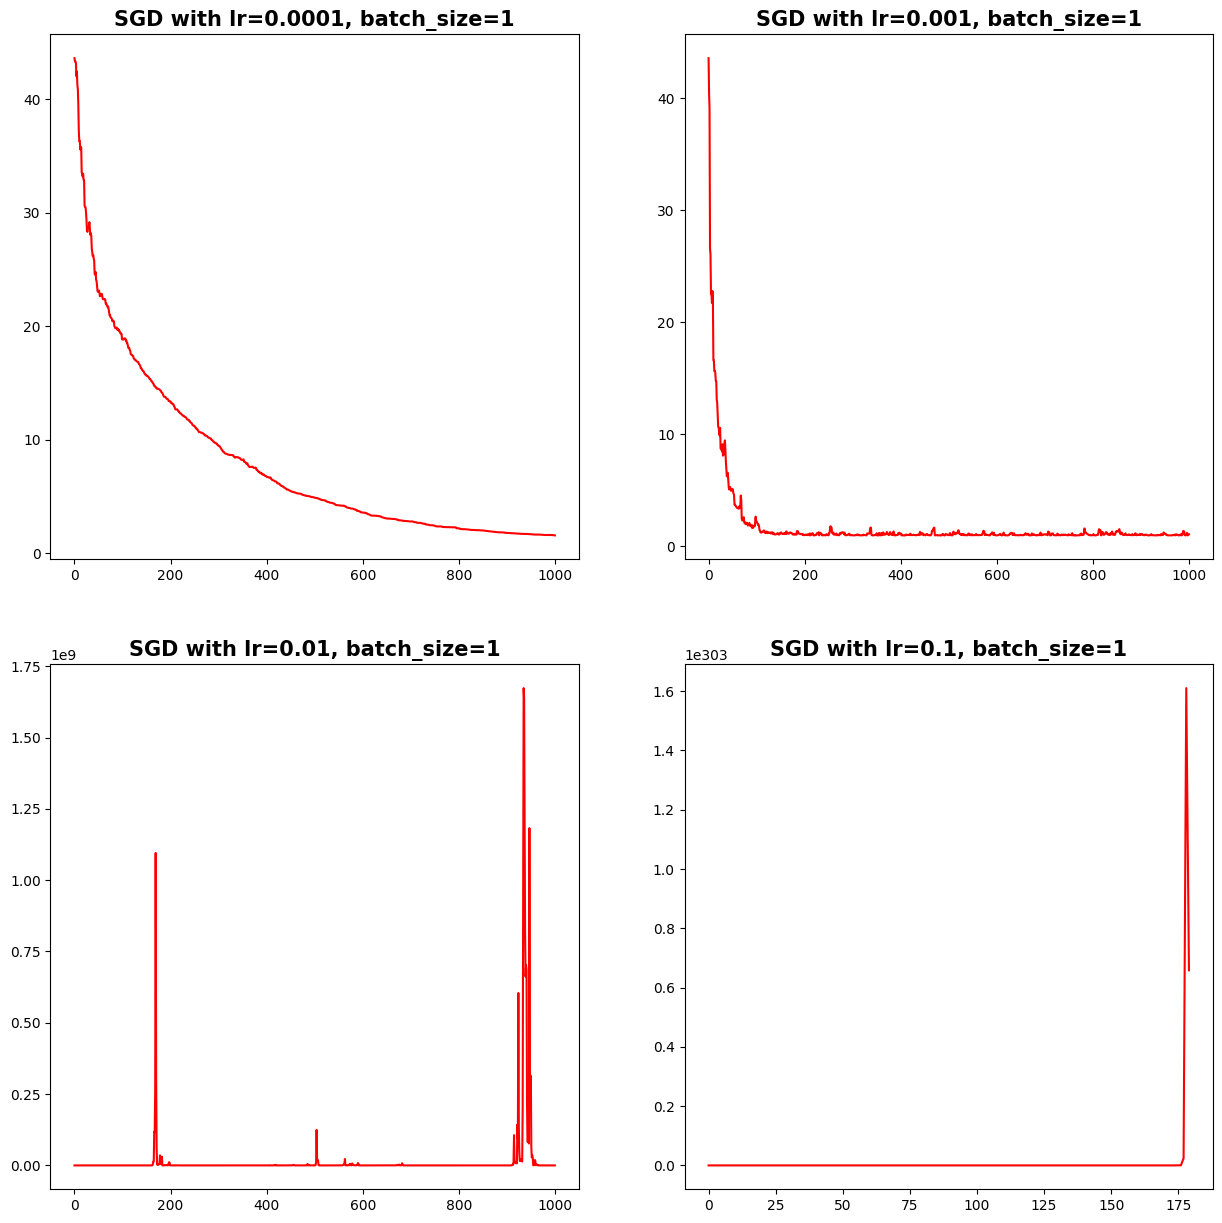

In [191]:
np.random.seed(42)
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(2, 2)
batch_size = 1
for lr, grd in zip([0.0001, 0.001, 0.01, 0.1],
                   [0, 1, 2, 3]):
    trace = stochastic_gradient_descent(X, start, Y, lr, batch_size, 1000)
    errors = np.array([mse(X, w, Y) for w in trace])
    ax = fig.add_subplot(gs[grd])
    ax.set_title(f'SGD with lr={lr}, batch_size={batch_size}', size=15, weight='heavy')
    ax.plot(np.arange(0, errors.shape[0]), errors, '-r')

Classic Stochastic Gradient Descent is even more more sensitive to `learning_rate` choice. Also you can notice that the plot of loss function values now oscillates. That is due to the fact that we estimate the gradient each time only on one object. Let us try increase `batch_size`.

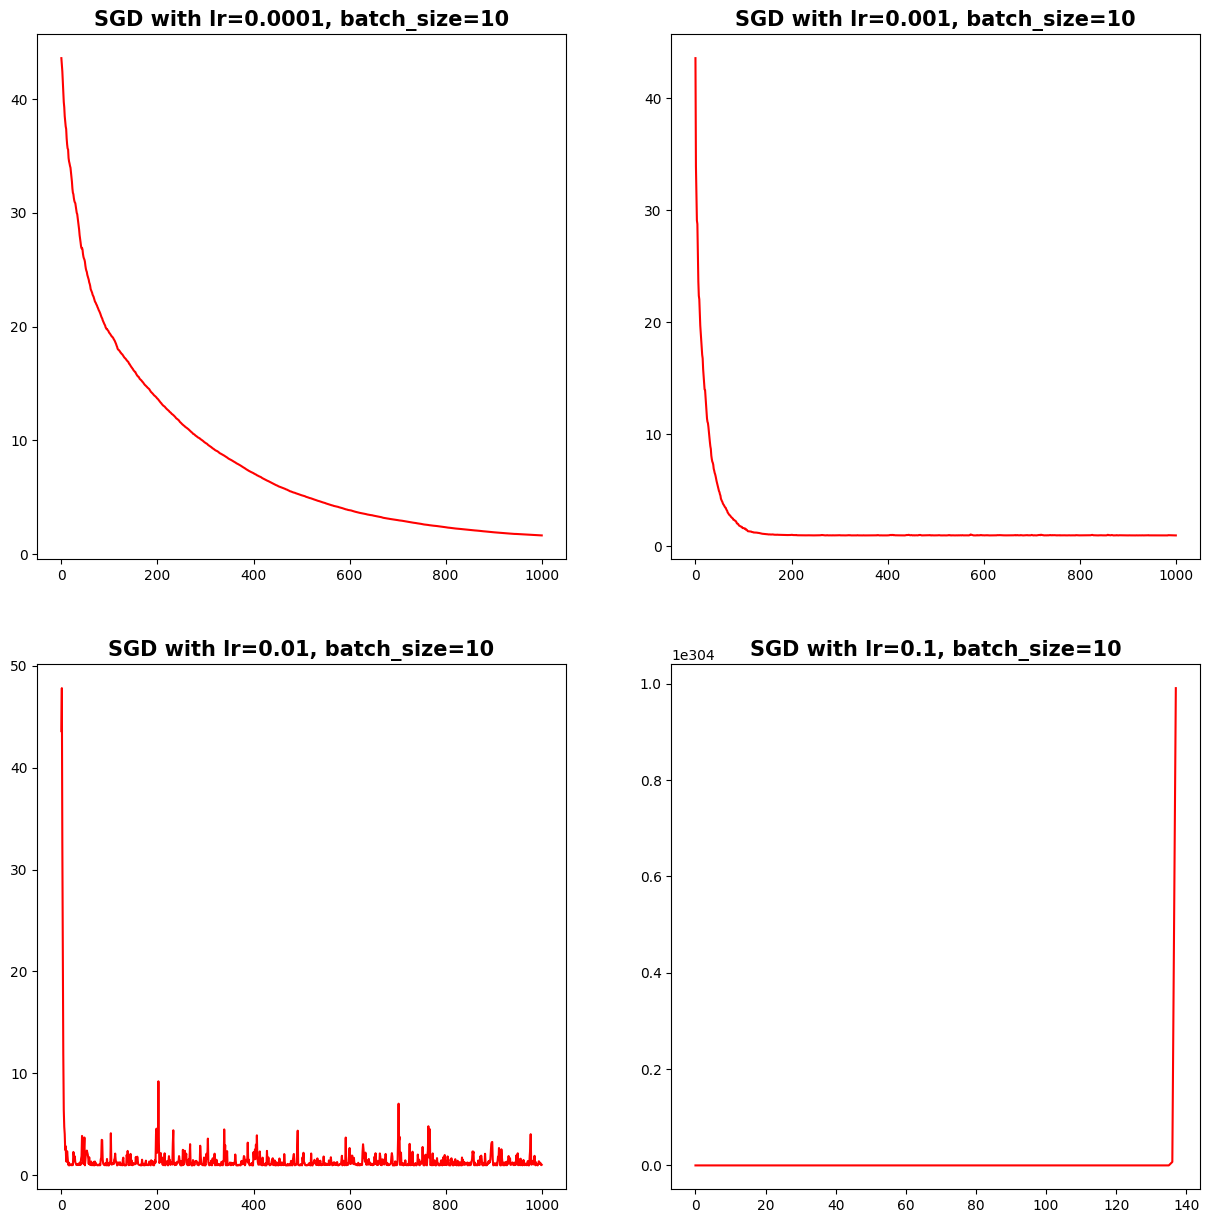

In [192]:
np.random.seed(42)
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(2, 2)
batch_size = 10
for lr, grd in zip([0.0001, 0.001, 0.01, 0.1],
                   [0, 1, 2, 3]):
    trace = stochastic_gradient_descent(X, start, Y, lr, batch_size, 1000)
    errors = np.array([mse(X, w, Y) for w in trace])
    ax = fig.add_subplot(gs[grd])
    ax.set_title(f'SGD with lr={lr}, batch_size={batch_size}', size=15, weight='heavy')
    ax.plot(np.arange(0, errors.shape[0]), errors, '-r')

The lines have become smoother. And also the third plot shows that with larger `batch_size` values it approaches regular Gradient Descent plot with the same parameters.

### PyTorch autograd

This is where the magic begins! In the functions earlier, you had to use a function you wrote yourself to calculate gradients. This is not an optimal way to do it. Especially considering that you had to first defferentiate the loss function. You wouldn't want to always do all these steps. Imagine that you're not using a popular loss function, but your own custom one.

It turns out that PyTorch can compute the gradients on its own. PyTorch's autograd is a key component of the library that enables automatic differentiation of functions. All you need is to use some predefined loss function from `torch.nn` like `torch.nn.MSELoss` for regression or `torch.nn.BCELoss` for classification tasks.

How to use autograd? When you define a tensor, you can specify that it requires gradients by setting the `requires_grad` parameter to `True`. PyTorch will then track all the operations that involve this tensor.

In [ ]:
seed_everything(42)
tensor = torch.rand(12, 6, requires_grad=True)

When you compute a function involving the tensor, PyTorch builds a computational graph that represents the sequence of operations involved in computing the function.

In [ ]:
result = torch.sqrt(torch.square(tensor).mean())

When you call the `backward()` method on the output tensor, PyTorch traces back through the computational graph and computes the gradients of the output tensor with respect to all the tensors that were involved in the computation.

In [ ]:
result.backward()

PyTorch then stores these gradients in the `grad` attribute of each tensor involved in the computation, allowing you to access the gradients and use them to update the tensor's values via an optimizer.

In [ ]:
tensor.grad

Yes, it is that simple. Now you can find the gradient of any function that is differentiable and can be written with PyTorch functions and methods.

#### Task 10 (0.5 point)

It is quite a good time for practice! Suppose we are solving the classification problem. There is the dataset $data$, the mextix of $weights$ and the $target$ matrix. Like in real life.

**Question**: `y_pred` should be log_softmax of $data * weights$ like in real models, `y_true` should be softmax of $target$. Compute the loss using `nn.KLDivLoss(reduction="batchmean")` of `y_pred` and `y_true`. Write down $\lVert \nabla_{weights} loss \rVert_F$. The answer will be a floating point value. Round it up to 3 decimal points.

**Sample answer**: `1.234`

**Warning**: do not change the seed!

In [ ]:
import torch.nn.functional as F
seed_everything(42)
data = torch.rand(100, 20, requires_grad=True)
weights = torch.rand(20, 5, requires_grad=True)
target = torch.rand(100, 5, requires_grad=True)
y_pred = # YOUR_CODE_HERE
y_true = # YOUR_CODE_HERE
loss = # YOUR_CODE_HERE
answer = # YOUR_CODE_HERE
answer

### Optimizers in PyTorch

You do not have to implement any optimizer from scratch. PyTorch already comprises implementations of the most popular ones. All you need - import torch and initialize the desired optimizer with hyperparameters that you want. You should pass the parameters of the model along with hyperparameters. The optimizer is to update only those parameters it has been initialize with.

In [ ]:
# model with parameters to be optimized
seed_everything(42)
model = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 1),
)

In [ ]:
lr = 3e-4
# initialize various optimizers
sgd = torch.optim.SGD(model.parameters(), lr=lr)
adagrad = torch.optim.Adagrad(model.parameters(), lr=lr)
adam = torch.optim.Adam(model.parameters(), lr=lr)
adamw = torch.optim.AdamW(model.parameters(), lr=lr)

These realizations from PyTorch do not do anything without already computed gradients. That means that we also need a differentiable loss function and the function that computes gradients. As you know, that is not a problem anymore.

That is how it works. First, we are to get predicts of the model:

In [ ]:
# first we get predicts
try:
    preds = model(X)
except Exception as e:
    print(f'Ooops. Something went wrong. The error occured: {e}')

One more common mistake. PyTorch models can process only `torch.tensor` data. Even more, all the data should be on the same device and the model as well. Linear layers require even the coincidence of types of values of model weights and features in our dataset. See:

In [ ]:
try:
    preds = model(torch.tensor(X))
except Exception as e:
    print(f'Ooops. Something went wrong. The error occured: {e}')

Fix it and finally get the outputs.

In [ ]:
preds = model(torch.tensor(X, dtype=torch.float32))

Now we need to define some loss function. Let it be MSE. As we have discovered earlier, we can use almost any function that can be written using PyTorch functions and methods.

In [ ]:
torch_mse = torch.square(torch.tensor(Y, dtype=torch.float32) - preds).mean()

We use `optimizer.zero_grad()` in PyTorch before making a step in order to clear the gradient values of all model parameters. This is necessary because PyTorch accumulates gradients by default, meaning that the gradients computed during each forward-backward pass are added to the gradients computed in previous passes. If we don't clear the gradients before making a step, the accumulated gradients will lead to incorrect parameter updates and poor convergence.

In [ ]:
adam.zero_grad()

Compute the gradients over all the tensors involved in operation of calculating the loss.

In [ ]:
torch_mse.backward()

Before making a step let us save the norm of the weights of the first layer to comapare.

In [ ]:
before_step = torch.linalg.norm(list(model.parameters())[0]).item()

Finally, we zero the gradients stored by the optimizer (otherwise they are aggregated by the optimizer which leads to unstable convergence) and make a step.

In [ ]:
adam.step()

Compare the norm of the weights of the first layer:

In [ ]:
after_step = torch.linalg.norm(list(model.parameters())[0]).item()

In [ ]:
after_step / before_step

#### Task 11 (1 point)

As you now know how to optimize the model, it time to practice it.

**Question**: using the same interface make exactly 1000 steps of `Adam` with `learning_rate=3e-4` and write down the norm of the weights of the first layer (without bias). Round the answer up to 3 decimal digits.

**Sample answer**: `1.234`

**Note**: the cell below comprises the code to reinitialize evrything with fixed seeds. Do not change the code to get reliable results.

In [ ]:
seed_everything(42)
model = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 1),
)
### START OF YOUR CODE ###
adam = ...
...
### END OF YOUR CODE ###
answer = np.around(torch.linalg.norm(list(model.parameters())[0]).item(), 3)
answer

**Be careful** with parameters. A common mistake:

- you make a model $Model_1$
- initialize optimizer $Adam(Model_1.parameters())$
- then you try other model $Model_2$
- and you do not initialize $Adam(Model_2.parameters())$ with new parameters
- this leads to updating the weights of $Model_1$ based on the gradients of $Model_2$

## Training loop

Now as we have found out how all the essential components of a neural network operate, we can make a training pipeline using the MNIST data we have defined at the beggining of this notebook.

The main algorithm:
1. Define the network architecture.
2. Define the loss function.
3. Define the optimizer.
4. Loop over the training dataset in batches:
    - Zero the gradients using optimizer.zero_grad().
    - Pass the input batch through the network to obtain the output.
    - Compute the loss between the output and the ground truth.
    - Backpropagate the gradients using loss.backward().
    - Update the model parameters using optimizer.step().
    - Track the loss and accuracy metrics.
5. Evaluate the model on the validation dataset (optional).
6. Repeat the loop for a fixed number of epochs or until convergence.

Let us step by step make the funal predictions. First, prepare the data using necessary transforms (may include augmentations, normalization, etc.).

In [ ]:
seed_everything(42)
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = MNIST(root='./data', train=True, download=True, transform=train_transform)
testset = MNIST(root='./data', train=False, download=True, transform=test_transform)

Make dataloaders to form the batches of data.

In [ ]:
seed_everything(42)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Define the model achitecture.

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self, num_hidden):
        super(MNIST_Net, self).__init__()
        self.fc1 = nn.Linear(784, num_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.fc3 = nn.Linear(num_hidden, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

Initialize the designed model.

In [ ]:
seed_everything(42)
model = MNIST_Net(128)

Choose the loss function that suits our task.

In [ ]:
loss = nn.CrossEntropyLoss()

Pick the optimization algorithm and learning_rate.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Now we are ready to make it all work!

In [ ]:
from tqdm.auto import tqdm

def train(model, epochs, train_loader, test_loader, criterion, optimizer):
    # make arrays to store the information about the epochs
    train_losses, test_losses = [], []
    train_accuracy, test_accuracy = [], []
    for epoch in tqdm(range(epochs)):
        # make arrays to store the information about the epoch
        epoch_train_losses, epoch_test_losses = [], []
        test_predicts, test_labels = [], []
        train_predicts, train_labels = [], []
        # iterate over batches of train_loader
        for batch in train_loader:
            data, target = batch[0], batch[1]
            # forward propagation
            predicts = model(data)
            # get loss
            loss = criterion(predicts, target)
            # zero previous grads of the layers
            optimizer.zero_grad()
            # backpropagation
            loss.backward()
            # update weights
            optimizer.step()
            # keep loss and labels
            epoch_train_losses.append(loss.item())
            train_predicts += predicts.tolist()
            train_labels += target.tolist()
        # save the mean loss of epoch
        train_losses.append(np.mean(epoch_train_losses))
        # save the accuracy of epoch
        train_accuracy.append((np.array(train_predicts).argmax(axis=1) == np.array(train_labels)).mean())

        # turn off the gradients computation for validation step
        with torch.no_grad():
            # iterate over test_loader
            for batch in test_loader:
                data, target = batch[0], batch[1]
                # forward propagation
                predicts = model(data)
                # get loss
                loss = criterion(predicts, target)
                # keep loss and labels
                epoch_test_losses.append(loss.item())
                test_predicts += predicts.tolist()
                test_labels += target.tolist()
        # save the mean loss of epoch
        test_losses.append(np.mean(epoch_test_losses))
        # save the accuracy of epoch
        test_accuracy.append((np.array(test_predicts).argmax(axis=1) == np.array(test_labels)).mean())
    return train_losses, test_losses, train_accuracy, test_accuracy, test_predicts, test_labels

Do you already see this magic? The training function does not depend on what kind of model we have, what kind of data we are using, what loss function and optimizer we have defined. Frankly speaking, there could be some "deviations" for example when we use augmentations rights inside this function, or when we have more than one exit point in the architecture, etc. But mainly the algorithm remains the same.

#### Task 12 (0.5 points)

Having the function for a training loop does not we can get the final result!

**Question**: use the `train` function to train the model for 10 epochs. Write down AUC-ROC score (with `multi_class='ovo'`) on test set after training using `test_predicts` and `test_labels` that the function returns. The answer will be a floating point value. Round it up to 3 decimal points.

**Sample answer**: `1.234`

**Warning**: Do not change the seed!

In [ ]:
seed_everything(42)
train_losses, test_losses, train_accuracy, test_accuracy, test_predicts, test_labels = # YOUR_CODE_HERE

In [ ]:
from sklearn.metrics import roc_auc_score
answer = # YOUR_CODE_HERE
answer

Let us look at the losses and accuracies of the model on the different epoches. That is how we can see whether the model is properly trained and nor overfitted.

In [ ]:
from matplotlib import gridspec

fig = plt.figure(figsize=(16, 7))
gs = gridspec.GridSpec(1, 2, figure=fig)
plt.suptitle('Training metrics', size=22, weight='heavy')

ax = fig.add_subplot(gs[0])
ax.plot(train_losses, 'b', label='train_loss')
ax.plot(test_losses, 'r', label='test_loss')
ax.set_title('Losses per epoch', size=18, weight='heavy')
ax.set_xlabel('epoch', size=14)
ax.set_ylabel('loss', size=14)

ax = fig.add_subplot(gs[1])
ax.plot(train_accuracy, 'b', label='train_accuracy')
ax.plot(test_accuracy, 'r', label='test_accuracy')
ax.set_title('Accuracy per epoch', size=18, weight='heavy')
ax.set_xlabel('epoch', size=14)
ax.set_ylabel('accuracy', size=14)

plt.show()

##### Congrats! Now you can train any network!